In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import sys
sys.path.append('../code')
import features
import dataframe_utilities as util

# Load Data

In [4]:
games = features.get_games()
batting = features.get_batting()
pitching = features.get_pitching()
pitchers = features.get_pitchers()

In [5]:
print("start hour vs. is_night_game")
print("night games seem to start from 5PM to 10PM")
games.groupby(games.start_time.str[:-3])['is_night_game'].agg(['mean','count'])

start hour vs. is_night_game
night games seem to start from 5PM to 10PM


,mean,count
start_time,,
1,0.004035,4709
10,0.997934,484
11,0.052632,19
12,0.007428,1077
2,0.003571,560
3,0.022609,575
4,0.045590,1009
5,0.980392,306
6,0.995685,1854


# Features

## Create dataset

In [6]:
df = games[['game_id','home_team_abbr','away_team_abbr','date','is_night_game']]
df['home_team_win'] = games.home_team_runs.astype('int')>games.away_team_runs

In [7]:
home_pitchers = pitchers[['name','game_id']].where((pitchers.is_home_team)&(pitchers.is_starting_pitcher)).dropna()
home_pitchers['home_pitcher'] = home_pitchers['name']
home_pitchers = home_pitchers.groupby('game_id')['home_pitcher'].first()
df = pd.merge(left=df, right=home_pitchers, on='game_id', how='left')

In [8]:
away_pitchers = pitchers[['name','game_id']].where((~pitchers.is_home_team)&(pitchers.is_starting_pitcher)).dropna()
away_pitchers['away_pitcher'] = away_pitchers['name']
away_pitchers = away_pitchers.groupby('game_id')['away_pitcher'].first()
df = pd.merge(left=df, right=away_pitchers, on='game_id', how='left')

In [9]:
df = df.sort_values(by='date').reset_index(drop=True)

## Add Small Feats

In [10]:
df['dh_game_no'] = pd.to_numeric(df['game_id'].str[-1:],errors='coerce')

In [11]:
#datetime
date = pd.to_datetime(df['date'])
df['season'] = date.dt.year
df['month']=date.dt.month
df['week_num'] = date.dt.week
df['dow']=date.dt.weekday.astype('int')

In [12]:
# df['matchup_season'] = df.apply(lambda x: sorted([x.away_team_abbr, x.home_team_abbr])[0] + '_' + 
#                          sorted([x.away_team_abbr, x.home_team_abbr])[1] + '_' +
#                          str(x.season),
#                          axis=1)
# df['game_num'] = df.groupby(by=['season','matchup_season'])['home_team_abbr'].cumcount()

In [13]:
from trueskill import rate_1vs1, Rating
def add_trueskill_ratings(df):
    #https://www.microsoft.com/en-us/research/project/trueskill-ranking-system/
    ratings = {}
    for x in df.home_team_abbr.unique():
        ratings[x]=25
    for x in df.away_team_abbr.unique():
        ratings[x]=25

    home_trueskill_pre = []
    away_trueskill_pre = []
    for i, r in df.iterrows():
        # get pre-match trueskill ratings from dict
        home_trueskill_pre.append(ratings[r.home_team_abbr])
        away_trueskill_pre.append(ratings[r.away_team_abbr])

        if r.date < df.date.max():
            #doubleheaders get screwed up if we do this on current day
            # update ratings dictionary with post-match ratings
            ts1 = Rating(ratings[r.home_team_abbr])
            ts2 = Rating(ratings[r.away_team_abbr])
            if r.home_team_win==1:
                ts1, ts2 = rate_1vs1(ts1, ts2)
            else:
                ts2, ts1 = rate_1vs1(ts2, ts1)
            ratings[r.home_team_abbr] = ts1.mu
            ratings[r.away_team_abbr] = ts2.mu

    df['home_trueskill_pre']= home_trueskill_pre
    df['away_trueskill_pre']= away_trueskill_pre
    df['ts_diff'] = df.home_trueskill_pre-df.away_trueskill_pre
    
    df.replace({np.inf: 0}, inplace=True)
    return df
df = add_trueskill_ratings(df)
df.shape

(24009, 16)

In [14]:
def add_rest_durations(df):
    # time between games for teams and pitchers
    df.date = pd.to_datetime(df.date)
    
    #initalize rest dictionary
    rest = {}
    for x in df.home_team_abbr.unique():
        rest[x]=pd.to_datetime('12-31-2009')
    for x in df.away_team_abbr.unique():
        rest[x]=pd.to_datetime('12-31-2009')
    for x in df.home_pitcher.unique():
        rest[x]=pd.to_datetime('12-31-2009')
    for x in df.away_pitcher.unique():
        rest[x]=pd.to_datetime('12-31-2009')

    # lists to temporairily hold results
    home_team_rest = []
    away_team_rest = []
    home_pitch_rest = []
    away_pitch_rest = []

    for i, r in df.iterrows():
        # get pre-match trueskill ratings from dict
        home_team_rest.append(r.date - rest[r.home_team_abbr])
        away_team_rest.append(r.date - rest[r.away_team_abbr])
        home_pitch_rest.append(r.date - rest[r.home_pitcher])
        away_pitch_rest.append(r.date - rest[r.away_pitcher])

        # update ratings dictionary with post-match ratings
        if r.date < df.date.max():
            #doubleheaders get screwed up if we do this on current day
            rest[r.home_team_abbr] = r.date
            rest[r.away_team_abbr] = r.date
            rest[r.home_pitcher] = r.date
            rest[r.away_pitcher] = r.date

    # add results to df
    df['home_team_rest']= home_team_rest
    df['away_team_rest']= away_team_rest
    df['home_pitcher_rest']= home_pitch_rest
    df['away_pitcher_rest']= away_pitch_rest

    for x in ['home_team_rest','away_team_rest','home_pitcher_rest','away_pitcher_rest']:
        df[x] = df[x].dt.days
        df[x] = df[x].clip(1,30)   # rest doesn't matter for large values

    # match comparisons
    df['team_rest_diff'] = df.home_team_rest - df.away_team_rest
    df['pitcher_rest_diff'] = df.home_pitcher_rest - df.away_pitcher_rest

    return df
df = add_rest_durations(df)
df.shape

(24009, 22)

In [15]:
df['date'] = (pd.to_datetime(df['date']) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s') #epoch time

## Add Stats

### Rolling Stats

In [16]:
# create rolling stat
b_stats = ['batting_avg','leverage_index_avg', 'onbase_perc', 'onbase_plus_slugging']
df = features.add_10RA_rolling(batting, df, b_stats, True, 'batting')

In [17]:
pitching['SO_batters_faced'] = pitching['SO'] / pitching['batters_faced']
pitching['H_batters_faced'] = pitching['H'] / pitching['batters_faced']
pitching['BB_batters_faced'] = pitching['BB'] / pitching['batters_faced']

# create rolling stat
b_stats = ['earned_run_avg','SO_batters_faced','H_batters_faced','BB_batters_faced']
df = features.add_10RA_rolling(pitching, df, b_stats, True, 'team_pitching')

In [18]:
pitchers['SO_batters_faced'] = pitchers['SO'] / pitchers['batters_faced']
pitchers['H_batters_faced'] = pitchers['H'] / pitchers['batters_faced']
pitchers['BB_batters_faced'] = pitchers['BB'] / pitchers['batters_faced']

# create rolling stat
b_stats = ['earned_run_avg','SO_batters_faced','H_batters_faced','BB_batters_faced']
df = features.add_10RA_rolling(pitchers, df, b_stats, False, 'pitcher')

### Game Stats

In [19]:
def game_stats(games,df):
    # make sure we have the same games in the same order in both df's
    games = games.sort_values(by=['date','game_id']).reset_index(drop=True)
    df = df.sort_values(by=['date','game_id']).reset_index(drop=True)
    assert all(games['game_id']==df['game_id'])
    
    games['home_team_season'] = games['home_team_abbr'] + '_' + df['season'].astype('str')
    games['away_team_season'] = games['away_team_abbr'] + '_' + df['season'].astype('str')
        
    # normalize spread for each team
    games['home_team_spread'] = games['spread']
    games['away_team_spread'] = -games['spread']
    
    names = ['home_team_errors_mean','home_team_errors_stdev','home_team_errors_skew',
            'away_team_errors_mean','away_team_errors_stdev','away_team_errors_skew',
            'home_team_spread_mean','home_team_spread_stdev','home_team_spread_skew',
            'away_team_spread_mean','away_team_spread_stdev','away_team_spread_skew']
    lists = {} 
    for n in names: lists[n]=[]
    
    # intitialize game stat lists
    errors = {}
    for t in games['home_team_season'].unique():errors[t]=[]
    for t in games['away_team_season'].unique():errors[t]=[]
    
    spread = {}
    for t in games['home_team_season'].unique():spread[t]=[]
    for t in games['away_team_season'].unique():spread[t]=[]
        
    for i,r in games.iterrows():
        m, s, sk = features.get_stats_from_dist(errors[r.home_team_season])
        lists['home_team_errors_mean'].append(m)
        lists['home_team_errors_stdev'].append(s)
        lists['home_team_errors_skew'].append(sk)
        m, s, sk = features.get_stats_from_dist(errors[r.away_team_season])
        lists['away_team_errors_mean'].append(m)
        lists['away_team_errors_stdev'].append(s)
        lists['away_team_errors_skew'].append(sk)
        m, s, sk = features.get_stats_from_dist(spread[r.home_team_season])
        lists['home_team_spread_mean'].append(m)
        lists['home_team_spread_stdev'].append(s)
        lists['home_team_spread_skew'].append(sk)
        m, s, sk = features.get_stats_from_dist(spread[r.away_team_season])
        lists['away_team_spread_mean'].append(m)
        lists['away_team_spread_stdev'].append(s)
        lists['away_team_spread_skew'].append(sk)
        
        #update dict with latest game
        errors[r['home_team_season']].append(r['home_team_errors'])
        errors[r['away_team_season']].append(r['away_team_errors'])
        spread[r['home_team_season']].append(r['home_team_spread'])
        spread[r['away_team_season']].append(r['away_team_spread'])

    # get differences
    error_diff = np.array(lists['home_team_errors_mean'])-np.array(lists['away_team_errors_mean'])
    spread_diff = np.array(lists['home_team_spread_mean'])-np.array(lists['away_team_spread_mean'])
    
    # add created rows into df
    for n in names:
        df[n]=lists[n]
    df['error_diff']=error_diff
    df['spread_diff']=spread_diff
    
    df = df.sort_values(by='date').reset_index(drop=True)
    return df

In [20]:
df = game_stats(games,df)
df.shape

(24009, 72)

### Season Stats

In [21]:
batting_stats = ['A', 'AB', 'BB', 'H', 'PA', 'PO', 'R', 'RBI', 'SO', 'batting_avg',
             'leverage_index_avg', 'onbase_perc', 'onbase_plus_slugging', 'pitches', 
             're24_bat', 'slugging_perc', 'strikes_total', 'wpa_bat', 'wpa_bat_neg', 
             'wpa_bat_pos']
df = features.add_season_rolling(batting, df, batting_stats, True,'batting')
df.shape

(24009, 212)

In [22]:
pitching_stats = ['BB', 'ER', 'H', 'HR', 'IP', 'R', 'SO', 'batters_faced',
               'earned_run_avg', 'game_score', 'inherited_runners',
               'inherited_score', 'inplay_fb_total', 'inplay_gb_total', 'inplay_ld',
               'inplay_unk', 'leverage_index_avg', 'pitches', 're24_def',
               'strikes_contact', 'strikes_looking', 'strikes_swinging',
               'strikes_total', 'wpa_def','SO_batters_faced','H_batters_faced',
                'BB_batters_faced']
# pitching_stats = ['BB', 'ER', 'H', 'HR', 'IP', 'R', 'SO', 'earned_run_avg', 
#                   'game_score', 'leverage_index_avg', 'pitches', 're24_def',
#                   'strikes_total', 'wpa_def','SO_batters_faced','H_batters_faced',
#                   'BB_batters_faced']
df = features.add_season_rolling(pitching, df, pitching_stats, True,'team_pitching')
df.shape

(24009, 401)

In [23]:
df = features.add_season_rolling(pitchers, df, pitching_stats, False,'pitcher')
df.shape

(24009, 590)

In [24]:
df.to_csv('../data/df_before_cleanup.csv', index=False)

# Cleanup

In [25]:
#fin na's
df = util.fix_na(df)

#drop duplicated columns
drop_cols = util.find_correlation(df,1)
df.drop(columns=drop_cols, inplace=True)
print(f"dropped {len(drop_cols)} columns")

dropped 425 columns


In [26]:
df.shape

(24009, 734)

In [27]:
df.to_csv('../data/df_w_features.csv', index=False)

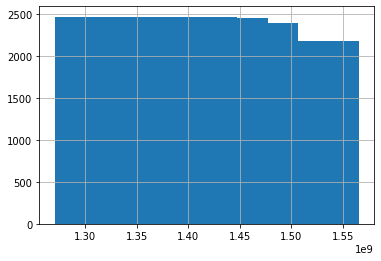

In [28]:
df.date.hist()